# [SunPy AIA deconvolution](https://aiapy.readthedocs.io/en/latest/_modules/aiapy/psf/deconvolve.html)

GPU accelerated [CuPy](https://cupy.dev/)
Crude implementation of RL algorithm, i.e. without regularization, meaning that the noise will tend to explode
Implicit mirror edge treatment
* Due to the discretization of the signal, the DFT assumes that the signal is one period of an infinite periodic signal
FFT convolution without zero-padding -> edge effects from one side of the image to the other ().

Deconvolution puts back energy to bright areas where it belongs. Bright regions become brighter, dark regions become darker. As a result, the contrast is enhanced. However, random intensity fluctuations caused by shot noise can be interpreted as signal and amplified by the deconvolution process. Without a regularization scheme, the deconvolution thus tends to enhance the noise.


In [1]:
import numpy as np
from soloEUI.processing.psf import PSF
from astropy.io import fits
from astropy.visualization import AsymmetricPercentileInterval, LinearStretch, LogStretch, ImageNormalize
import matplotlib.pyplot as plt
from watroo.utils import richardson_lucy
from sunpy.visualization.colormaps import cm

pre_flare_image = fits.getdata(r"data/solo_L1_eui-hrieuv174-image_20220302T173200310_V00.fits").astype(np.float64)
# pre_flare_image += fits.getdata(r"data/solo_L1_eui-hrieuv174-image_20220302T173000310_V00.fits").astype(np.float64)
# pre_flare_image /= 2
flare_image = fits.getdata(r"data/solo_L1_eui-hrieuv174-image_20220302T173400310_V00.fits").astype(np.float64)
flare_image -= pre_flare_image
mercury_image = fits.getdata(r"data/solo_L1_eui-hrieuv174-image_20230103T074426163_V00.fits")
cmap = plt.get_cmap('solar orbiterhri_euv174')

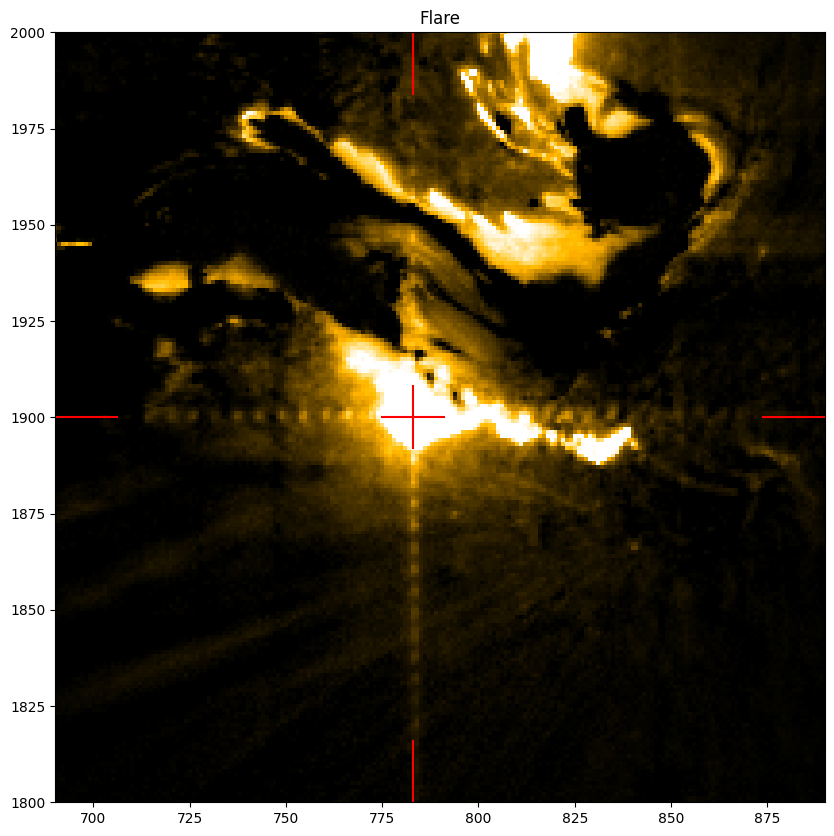

In [2]:
flare_core = 783, 1900  # (x, y)
x_lim = 690, 890
y_lim = 1800, 2000
x_width = x_lim[1] - x_lim[0] + 1
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(flare_image, origin='lower', cmap=cmap, vmin=0, vmax=16383)
length = 16
ax.plot((x_lim[0], x_lim[0] + length), (flare_core[1], flare_core[1]), 'r')
ax.plot((x_lim[1], x_lim[1] - length), (flare_core[1], flare_core[1]), 'r')
ax.plot((flare_core[0], flare_core[0]), (y_lim[0], y_lim[0] + length), 'r')
ax.plot((flare_core[0], flare_core[0]), (y_lim[1], y_lim[1] - length), 'r')
ax.plot((flare_core[0], flare_core[0]), (flare_core[1] - length // 2, flare_core[1] + length // 2), 'r')
ax.plot((flare_core[0] - length // 2, flare_core[0] + length // 2), (flare_core[1], flare_core[1]), 'r')
ax.set_xlim(*x_lim)
ax.set_ylim(*y_lim)
_ = ax.set_title('Flare')

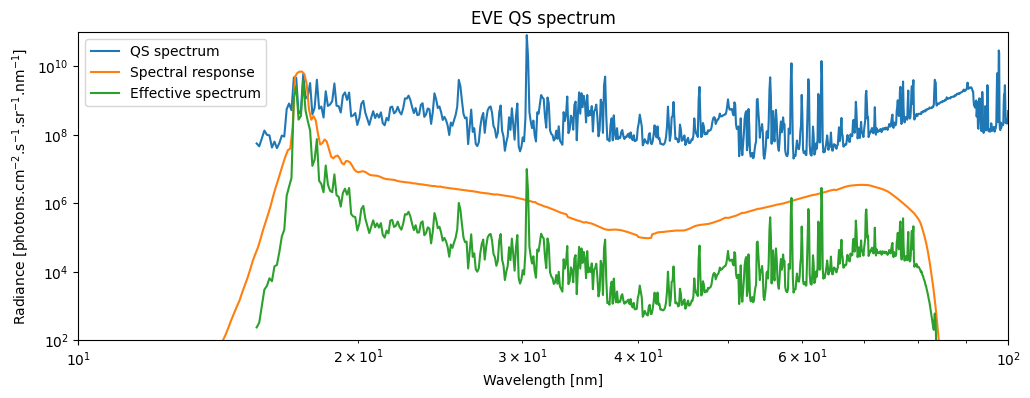

In [3]:
spectrum_waves, spectrum = np.loadtxt(r"data/EVE_QS_20080327_0000_2400.txt", comments=';').T
response_waves, response = np.loadtxt(r"data/HRI_Efficiency_SN10_V1.txt", comments=';').T
effective_spectrum = spectrum * np.interp(spectrum_waves, response_waves, response, left=0, right=0)
valid = (effective_spectrum > 0) & (spectrum_waves > 15.5)
effective_spectrum = effective_spectrum[valid]
spectrum_waves = spectrum_waves[valid]
spectrum = spectrum[valid]
fix, ax = plt.subplots(figsize=(12, 4))
ax.plot(spectrum_waves, spectrum, label='QS spectrum')
ax.plot(response_waves, response * 1e10, label = 'Spectral response')
ax.plot(spectrum_waves, effective_spectrum, label='Effective spectrum')
ax.set_title('EVE QS spectrum')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Radiance [photons.cm$^{-2}$.s$^{-1}$.sr$^{-1}$.nm$^{-1}$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 100)
ax.set_ylim(1e2, 1e11)
_ = ax.legend()

## Computation of the EUI/HRI PSF

In [ ]:
spectral_psf = []
n_first = 100
sort = np.argsort(effective_spectrum)[-n_first:]
wavelengths = [w * 1e-6 for w in spectrum_waves[sort]]
polychromatic_psf = PSF('hrieuv')
polychromatic_psf.make_psf(wavelengths, weights=effective_spectrum[sort],
                         q0=7, m=15, to_fits=True, wfe=False, x_pix=flare_core[0], y_pix=flare_core[1])

wavelength = 17.4e-6
monochromatic_psf = PSF('hrieuv')
monochromatic_psf.make_psf(wavelength, q0=7, m=15, to_fits=False, wfe=False, x_pix=flare_core[0], y_pix=flare_core[1])

 31%|███       | 31/100 [17:22<36:02, 31.34s/it]  

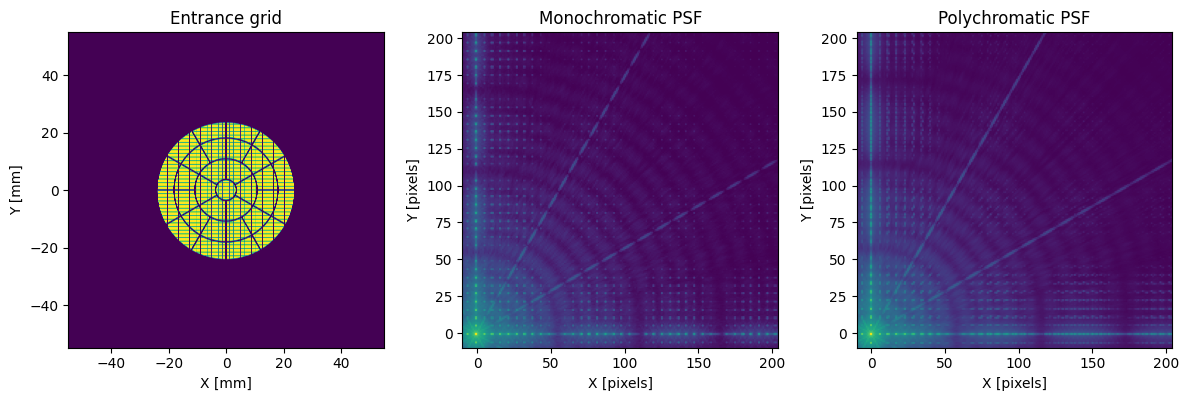

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
extent = polychromatic_psf.grid.x.min(), polychromatic_psf.grid.x.max(), polychromatic_psf.grid.y.min(), polychromatic_psf.grid.y.max()
axes[0].imshow(polychromatic_psf.grid.map, extent=extent)
axes[0].set_title('Entrance grid')
axes[0].set_xlabel('X [mm]')
axes[0].set_ylabel('Y [mm]')
norm = ImageNormalize(polychromatic_psf.map, interval=AsymmetricPercentileInterval(0, 100), stretch=LogStretch(1e8))
for ax, image, title in zip(axes[1:], (monochromatic_psf.map, polychromatic_psf.map), ('Monochromatic PSF', 'Polychromatic PSF')):
    shp = polychromatic_psf.map.shape
    ax.imshow(image, norm=norm, extent=(-shp[1] // 2, shp[1] // 2, -shp[0] // 2, shp[0] // 2))
    ax.set_xlim(-10, shp[1] // 2)
    ax.set_ylim(-10, shp[0] // 2)
    ax.set_title(title)
    ax.set_xlabel('X [pixels]')
    ax.set_ylabel('Y [pixels]')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for i, (ax, title, flare_profile, diffraction_profile, full_profile) in  enumerate(zip(
        axes,
        ('X profile', 'Y profile'),
        (flare_image[flare_core[1], :] / 1e7, flare_image[:, flare_core[0]] / 1e7),
        (polychromatic_psf.map[polychromatic_psf.map.shape[0] // 2, :], polychromatic_psf.map[:, polychromatic_psf.map.shape[1] // 2]),
        (monochromatic_psf.map[monochromatic_psf.map.shape[0] // 2, :], monochromatic_psf.map[:, monochromatic_psf.map.shape[1] // 2]))):
    x_flare = np.linspace(-flare_core[i], flare_image.shape[1-i] - flare_core[i] - 1, flare_image.shape[1-i])
    x_psf = np.linspace(-polychromatic_psf.map.shape[1-i] // 2 + 1, polychromatic_psf.map.shape[1-i] // 2, polychromatic_psf.map.shape[1-i])
    x_full = np.linspace(-monochromatic_psf.map.shape[1-i] // 2 + 1, monochromatic_psf.map.shape[1-i] // 2, monochromatic_psf.map.shape[1-i])
    ax.plot(x_flare, flare_profile, label='Flare')
    ax.plot(x_full, full_profile, label='Monochromatic psf')
    ax.plot(x_psf, diffraction_profile, label='Polychromatic psf')
    ax.set_title(title)
    ax.set_xlim(min(x_psf), max(x_psf))
    ax.set_xlim(-100, 100)
    ax.set_ylim(1e-6, 5e-1)
    ax.set_yscale('log')
    ax.grid('on')
    ax.legend()
plt.tight_layout()

The peaks broaden with spectral order due to the increased spectral dispersion. At order 14, two peaks are visible. The separation of the Fe$_9$ and Fe$_{X}$ lines is given by

In [7]:
lambda_fe9 = 17.1073e-6
lambda_fe10 = 17.4531e-6
order = 14
separation = np.degrees(order * (lambda_fe10 - lambda_fe9) / polychromatic_psf.grid.mesh_pitch) * 3600 / polychromatic_psf._plate_scale
print(f'Separation {separation:5.3f} pixels')

Separation 1.598 pixels


## Deconvolution

In [8]:
iterations = [2, 10, 50]
images = [mercury_image]
for it in iterations:
    images.append(richardson_lucy(mercury_image, polychromatic_psf.map, iterations=it, fft=True, denoise_coefficients=(10, 5, 1)))

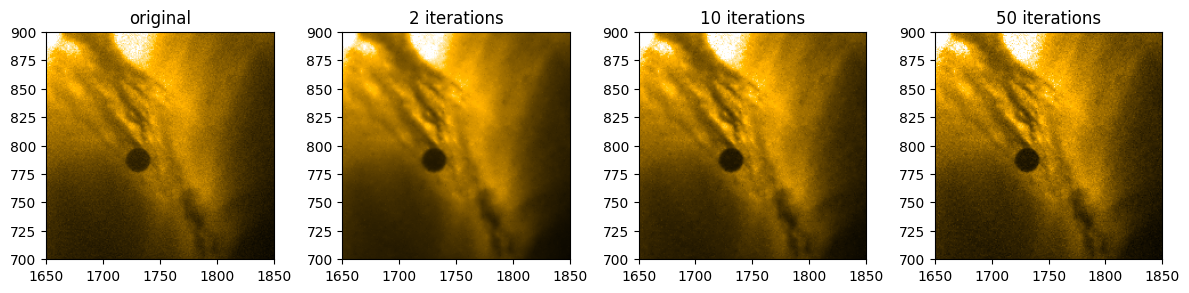

In [9]:
fig, axes = plt.subplots(1, 1 + len(iterations), figsize=((1 + len(iterations)) * 3, 4))
norm = ImageNormalize(images[-1][700:900, 1650:1850], interval=AsymmetricPercentileInterval(0, 99), stretch=LinearStretch())
labels = ['original', *[f'{it} iterations' for it in iterations]]
for ax, image, label in zip(axes, images, labels):
    ax.imshow(image, origin='lower', norm=norm, cmap=cmap)
    ax.set_xlim(1650, 1850)
    ax.set_ylim(700, 900)
    ax.set_title(label)
plt.tight_layout()

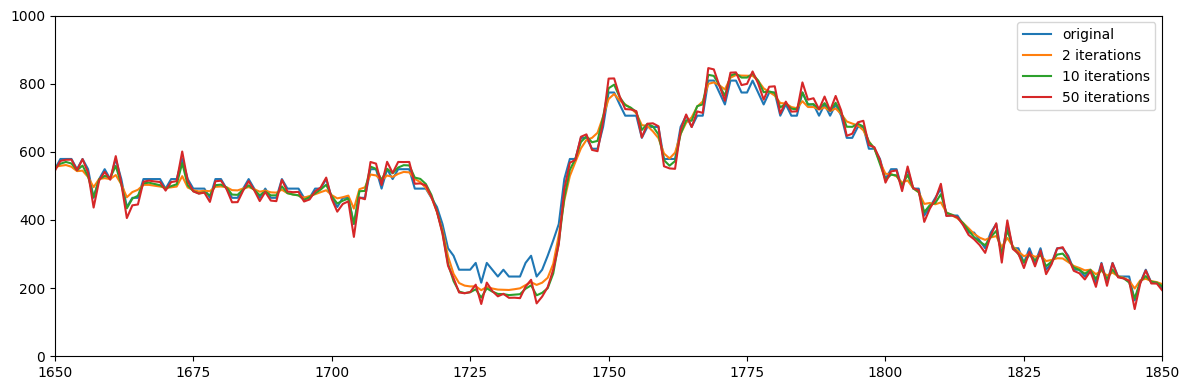

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for image, label in zip(images, labels):
    ax.plot(image[786, :], label=label)
ax.set_xlim(1650, 1850)
ax.set_ylim(0, 1000)
ax.legend()
plt.tight_layout()

## Computation of the diffraction pattern with the FFT

The electric field on a screen at a distance $z_0$ from the mask is given by
$E(x) \propto \int_{x'} M(x')\exp\left(\frac{-2i\pi x' x}{\lambda z'}\right)dx'$
with

$M(x')=E_i(x')A(x')\exp\left(\frac{i\pi x'^2}{\lambda z'}\right)$

Discretization:

$E(x^k) \propto \sum_{j=0}^{N-1}M(x_j')\exp\left(\frac{-2i\pi x_j'x_k}{\lambda z'}\right)$

Posing

$x_j'=j\Delta x'$ and $x^k=k\Delta x$

we have

$E(x_k) \propto \sum_{j=0}^{N-1}M(x_j')\exp\left(\frac{-2i\pi j\Delta x_k'\Delta x}{\lambda z'}\right)$

The FFT computes

$E_k = \frac{1}{N} \sum_{j=0}^{N-1}M_j\exp\left(\frac{-2i\pi jk}{N}\right)$

Identification of the terms gives

$\frac{jk}{N} = \frac{j\Delta x_k'\Delta x}{\lambda z'}$

whence

$\Delta x=\frac{\lambda z'}{N\Delta x'}$

### At infinity: Fraunhofer diffraction
$M(x^j')\xrightarrow[z' \to \infty]{} E_i(x^j')A(x^j')$

The diffraction is computed by the FFT at discrete angles $\alpha^k$ given by
$\alpha^k=k\frac{\Delta x}{z'}=k\frac{\lambda}{N\Delta x'}=k\Delta\alpha$

### Choice of sampling

Since the grid pitch is a multiple of the thickness $T$ of the rods, we choose $\Delta_x$ to be a sub-multiple of the width of the rods, so that each cell is sampled identically:
$\Delta x'=\frac{T}{q}$ with $q \in \mathbb{N}$

This also forces $\Delta \alpha$ to be set, while we want to compute $E_k$ at angles corresponding to the plate scale $P$ (expressed in radians) or its submultiples:

$\Delta\alpha = \frac{P}{m}$ with $m \in \mathbb{N}$
Both conditions can't be jointly fulfilled strictly, for:
$\Delta \alpha=\frac{\lambda}{N\Delta x'}=\frac{P}{m}\implies m=\frac{NPT}{q\lambda}\notin \mathbb{N}$
since $N$ is an integer. Conversely, the $N$ that gives the closest approximation to the desired $m$ is
$N=\frac{mq\lambda}{PT}$
rounded to the nearest integer. Rounding implies that in practice is not an integer. The diffraction is thus computed at angles that are not submultiples of the plate scale. However, the relative error on $m$ is at most $1 / 2N$.

The physical width of the map that represents the diffracting aperture is given by
$N\Delta x'=m\frac{\lambda}{P}$
which means that $m$ has to be sufficiently large so that $N\Delta x_0$ is larger than the aperture.
The width of the diffraction map is given by
$N\Delta\alpha=q\frac{\lambda}{T}$

### Polychromatic PSF

The diffraction pattern is a function of the incident wavelength. The solar radiation being polychromatic, the total PSF is the sum of the PSFs at all wavelengths. We want the angular sampling $\Delta\alpha$ and the oversampling factor $m$ to remain the same at all wavelengths. The integer $N$ that gives the best approximation to the desired integer $m$ increases with $\lambda$, which slows down the computations. However, since we do not need to compute at angles larger than $N_0\Delta\alpha$, it is possible to decrease $q$ to the largest value that still ensures $N\geq N_0$. This condition is also sufficient to ensure that the coverage of the entrance aperture is at least that with the shortest wavelength. Indeed:

$\frac{N\Delta x'}{N_0\Delta x_0'}=\frac{N}{N_0}\frac{q_0}{q}$

And thus $N\Delta x' \geq N_0\Delta x_0'$ since $N\geq N_0$ and $q_0 \geq q$